In [1]:
import pandas as pd
import numpy as np
import os
import sys

parent_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
helper_path = os.path.join(parent_path, "Data_Workflow")
sys.path.append(helper_path)
from DataHelper import *

TARGET = "total load actual"
BM = "total load forecast"
PCA_n_components = 20

os.chdir("../Data/Selected_Features")
df = pd.read_csv("raw_all_features_dataset.csv")
df["time"] = pd.to_datetime(df["time"], utc=True).dt.tz_convert("CET")
df.set_index("time", inplace=True)

train, validation, test = split_train_test_validation(df, df.index)
train_start, train_end, valid_start, valid_end, test_start, test_end =  train.index[0], train.index[-1], validation.index[0], validation.index[-1], test.index[0], test.index[-1]
print(f"Training set starts at {train_start} and ends at {train_end}.")
print(f"Validation set starts at {valid_start} and ends at {valid_end}")
print(f"Testing set starts at {test_start} nd ends at {test_end}")

X_features = df.columns.copy().tolist()
X_features.remove(TARGET)

os.chdir("..")
bm_df = pd.read_csv("load_benchmark.csv")
bm_df["time"] = pd.to_datetime(bm_df["time"], utc=True).dt.tz_convert("CET")
bm_df.set_index("time", inplace=True)

os.chdir("../Models/Results")

Training set starts at 2015-01-01 00:00:00+01:00 and ends at 2017-10-19 16:00:00+02:00.
Validation set starts at 2017-10-19 17:00:00+02:00 and ends at 2018-05-26 20:00:00+02:00
Testing set starts at 2018-05-26 21:00:00+02:00 nd ends at 2018-12-31 23:00:00+01:00


For the modelling part, we will be applying three deep neural networks. Specifically, we will be using LSTM, Stacked LSTM, and CNN LSTM.

# 1.0 Process Data

To optimize our model's performance, we will first apply Principal Component Analysis (PCA) to reduce the dimensionality of the dataset. Specifically, we will reduce the dataset to 20 principal components. This step helps eliminate redundant features and noise while retaining the most critical patterns in the data. After transforming the data using PCA, we will apply a min-max scaler fitted on the training set and subsequently applied to the entire dataset to normalize the feature values.

After these transformations, we will create sliding windows to prepare the data for model training. Each sliding window will consist of 48 consecutive hours of data, which will be used to predict the target value for the 49th hour. This allows the model to learn temporal dependencies and capture patterns over two-day periods, enabling it to make informed predictions.

For each window, the target variable (total load actual) is shifted by 1 hour. This means that after using a 48-hour window to predict the 49th hour, the window will shift forward by one hour to create the next training sample. This method ensures the model captures sequential patterns and uses past data to make hourly predictions.

By leveraging PCA for dimensionality reduction and the sliding window approach for time series forecasting, this pipeline efficiently captures the temporal dynamics of the dataset, enhancing both the model's computational efficiency and its ability to generalize to future predictions.

In [2]:
processed_df, processed_index, min_val, max_val = model_data_process(df, TARGET, train_end, X_features, PCA_n_components)

predict_window = 48 # Number of past hours used to predict future
hourly_steps = 1 # Number of hour(s) to predict

X_train, y_train = DNN_create_sliding_windows(processed_df, processed_index, train_start, train_end, predict_window, hourly_steps)
X_valid, y_valid = DNN_create_sliding_windows(processed_df, processed_index, valid_start, valid_end, predict_window, hourly_steps)
X_test, y_test = DNN_create_sliding_windows(processed_df, processed_index, test_start, test_end, predict_window, hourly_steps)

train, valid = DNN_shuffle((X_train, y_train), (X_valid, y_valid))

# 2.0 LSTM

In [3]:
single_history = fit_lstm(X_train, train, valid, "../")

Epoch 1/150
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0275 - root_mean_squared_error: 0.1528
Epoch 1: val_loss improved from inf to 0.00596, saving model to ../lstm.keras
765/765 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.0274 - root_mean_squared_error: 0.1527 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0772 - learning_rate: 6.0000e-04
Epoch 2/150
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0064 - root_mean_squared_error: 0.0798
Epoch 2: val_loss improved from 0.00596 to 0.00447, saving model to ../lstm.keras
765/765 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0064 - root_mean_squared_error: 0.0798 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0669 - learning_rate: 7.2514e-04
Epoch 3/150
764/765 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0045 - root_mean_squared_error: 0.0672
Epoch 3: val_loss improved from 0.00447 to 0.00306, saving model to ../lstm.keras
765/765 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0045 - root_mean_squared_error: 0.0671 - v

File is saved.


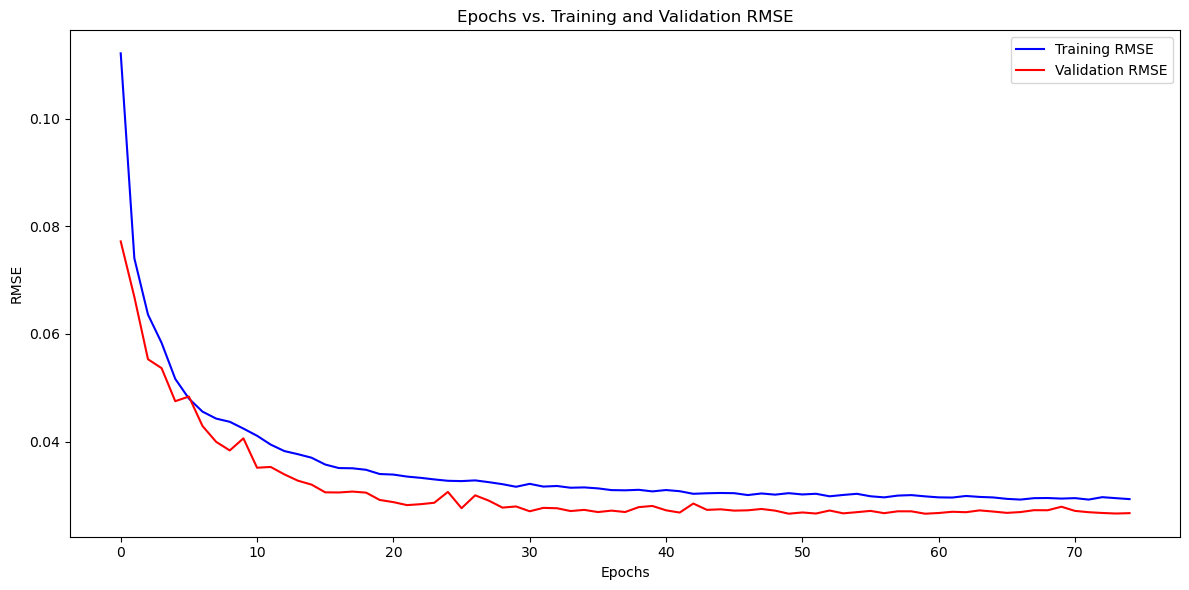

In [4]:
plot_model_rmse(single_history, "../History/lstm.csv")

In [5]:
lstm_results, lstm_predictions = DNN_predict(X_test, y_test, TARGET, min_val, max_val, "../lstm.keras")
lstm_preds_df = pd.DataFrame(lstm_predictions, index=test.index[predict_window:], columns=["Results"])
save_file(lstm_preds_df, "lstm_pred.csv")
lstm_results

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 48, 100)        │        48,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 150)            │       720,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,076,406 (11.74 MB)

 Trainable params: 769,101 (2.93 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,307,305 (8.80 MB)

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
File is saved.


,MSE,RMSE,MAE,MAPE
0,357456.813984,597.876922,394.633718,1.383875


# 3.0 Stacked LSTM

In [3]:
stacked_history = fit_stacked_lstm(X_train, train, valid, "../")

Epoch 1/150
764/765 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0188 - root_mean_squared_error: 0.1306
Epoch 1: val_loss improved from inf to 0.00571, saving model to ../stacked_lstm.keras
765/765 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - loss: 0.0188 - root_mean_squared_error: 0.1306 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0756 - learning_rate: 0.0010
Epoch 2/150
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0059 - root_mean_squared_error: 0.0760
Epoch 2: val_loss improved from 0.00571 to 0.00441, saving model to ../stacked_lstm.keras
765/765 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.0059 - root_mean_squared_error: 0.0760 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0664 - learning_rate: 0.0012
Epoch 3/150
764/765 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0036 - root_mean_squared_error: 0.0596
Epoch 3: val_loss improved from 0.00441 to 0.00332, saving model to ../stacked_lstm.keras
765/765 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.0036 - root_mean_squared_e

File is saved.


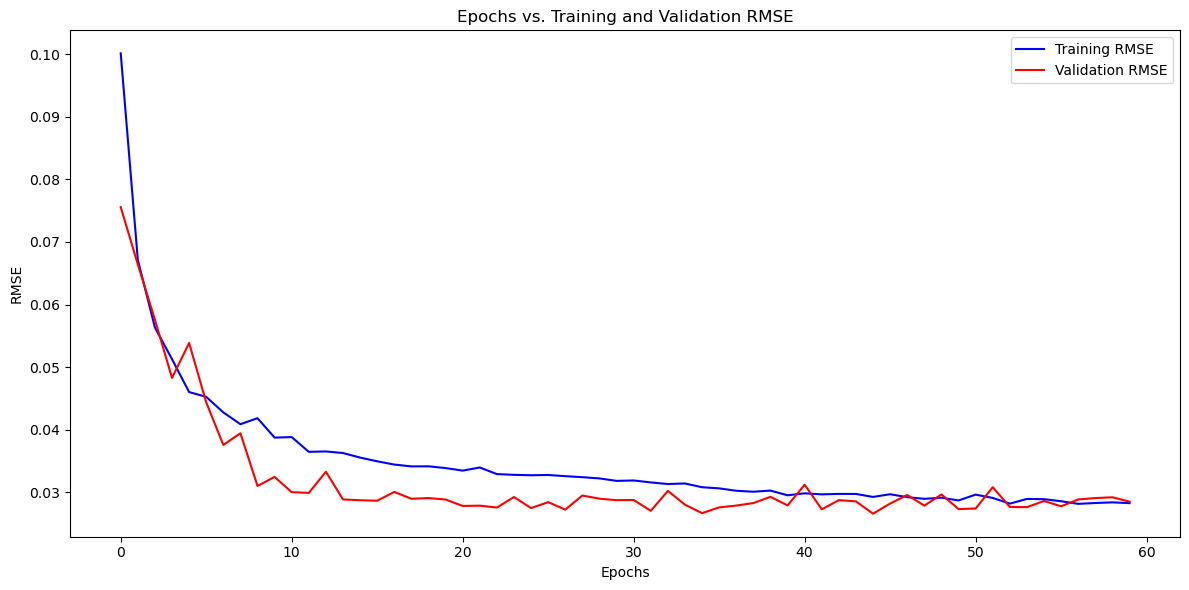

In [4]:
plot_model_rmse(stacked_history, "../History/stacked_lstm.csv")

In [5]:
stacked_lstm_results, stacked_lstm_predictions = DNN_predict(X_test, y_test, TARGET, min_val, max_val, "../stacked_lstm.keras")
slstm_preds_df = pd.DataFrame(stacked_lstm_predictions, index=test.index[predict_window:], columns=["Results"])
save_file(slstm_preds_df, "stacked_lstm_pred.csv")
stacked_lstm_results

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 48, 200)        │       177,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 48, 100)        │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       480,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,112,806 (11.87 MB)

 Trainable params: 778,201 (2.97 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,334,605 (8.91 MB)

163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
File is saved.


,MSE,RMSE,MAE,MAPE
0,333108.800068,577.155785,377.066984,1.331062


# 4.0 CNN LSTM

In [3]:
cnn_lstm_history = fit_cnn_lstm(X_train, train, valid, "../")

Epoch 1/150
763/765 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0214 - root_mean_squared_error: 0.1394
Epoch 1: val_loss improved from inf to 0.00626, saving model to ../cnn_lstm.keras
765/765 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.0214 - root_mean_squared_error: 0.1393 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0791 - learning_rate: 0.0010
Epoch 2/150
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0057 - root_mean_squared_error: 0.0751
Epoch 2: val_loss improved from 0.00626 to 0.00383, saving model to ../cnn_lstm.keras
765/765 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 0.0057 - root_mean_squared_error: 0.0751 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0619 - learning_rate: 0.0012
Epoch 3/150
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0037 - root_mean_squared_error: 0.0610
Epoch 3: val_loss improved from 0.00383 to 0.00346, saving model to ../cnn_lstm.keras
765/765 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.0037 - root_mean_squared_error: 0.0610

File is saved.


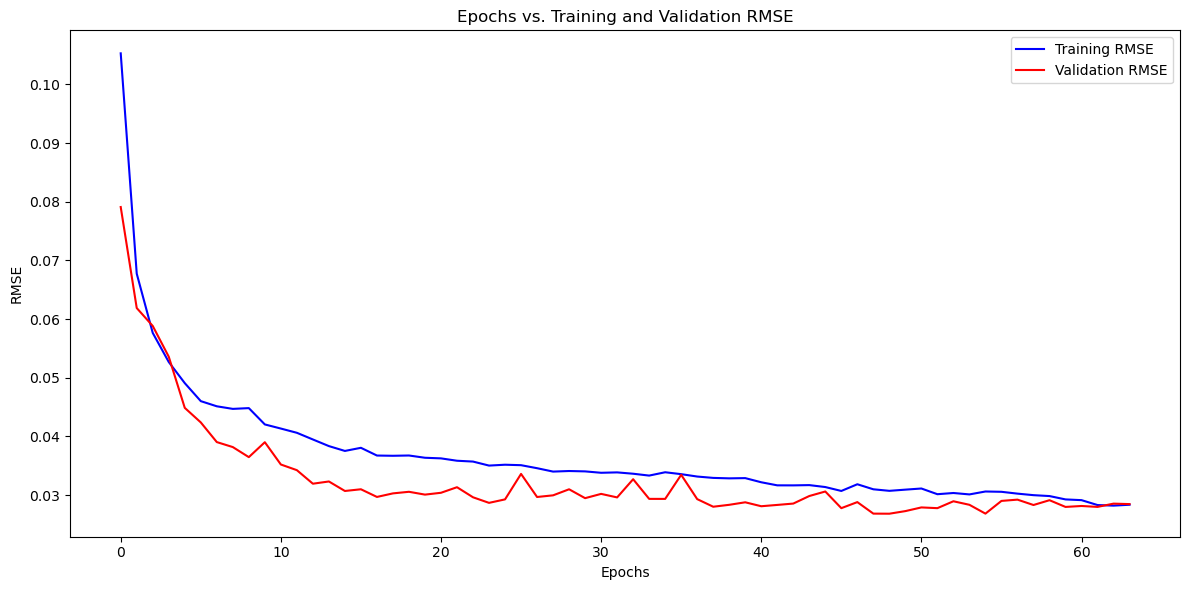

In [4]:
plot_model_rmse(cnn_lstm_history, "../History/cnn_lstm.csv")

In [5]:
cnn_lstm_results, cnn_lstm_predictions = DNN_predict(X_test, y_test, TARGET, min_val, max_val, "../cnn_lstm.keras")
cnnlstm_preds_df = pd.DataFrame(cnn_lstm_predictions, index=test.index[predict_window:], columns=["Results"])
# save_file(cnn_lstm_results, "cnn_lstm_results.csv", False)
save_file(cnnlstm_preds_df, "cnn_lstm_pred.csv")
cnn_lstm_results

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 48, 64)         │         2,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 48, 150)        │       129,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 48, 100)        │       100,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       480,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,849,414 (10.87 MB)

 Trainable params: 712,353 (2.72 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,137,061 (8.15 MB)

163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
File is saved.


,MSE,RMSE,MAE,MAPE
0,337914.802598,581.304398,388.112756,1.3773


# 5.0 Final Notes

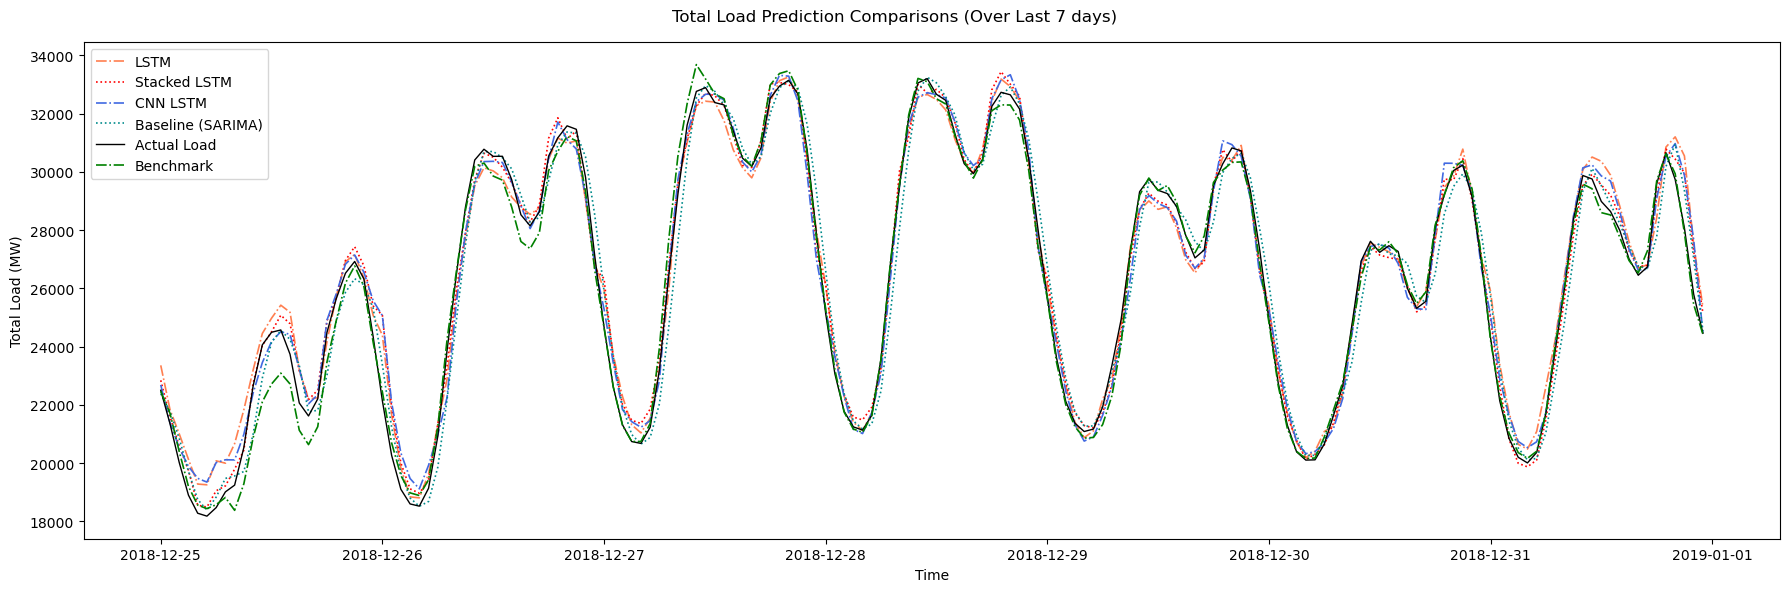

,MSE,RMSE,MAE,MAPE
LSTM,357456.809701,597.876919,394.633719,1.383875
Stacked LSTM,333108.812375,577.155796,377.067001,1.331062
CNN LSTM,337914.795848,581.304392,388.112757,1.377300
Baseline (SARIMA),772077.950824,878.679663,601.006380,2.118588
Benchmark,154486.870875,393.048179,257.940330,0.886564


In [2]:
lstm_pred_df = pd.read_csv("lstm_pred.csv")
stacked_lstm_pred_df = pd.read_csv("stacked_lstm_pred.csv")
cnn_lstm_history_lstm_pred_df = pd.read_csv("cnn_lstm_pred.csv")
baseline_df = pd.read_csv("baseline_pred.csv")
actual_df = bm_df[[TARGET]].reset_index()
forecast_df = bm_df[[BM]].reset_index()

model_prediction_dfs = {"LSTM": lstm_pred_df, "Stacked LSTM": stacked_lstm_pred_df, "CNN LSTM": cnn_lstm_history_lstm_pred_df, "Baseline (SARIMA)": baseline_df, "Actual Load": actual_df,"Benchmark": forecast_df}
for model_name, df in model_prediction_dfs.items():
    df["time"] = pd.to_datetime(df["time"], utc=True).dt.tz_convert("CET")
    df.set_index("time", inplace=True)
prediction_df = pd.concat(list(model_prediction_dfs.values()), axis=1)
prediction_df.dropna(inplace=True)
prediction_df.columns = list(model_prediction_dfs.keys())

n = 7
window = -24*n # last n days starting from the last hourly period
plot_linegraphs_target(prediction_df.iloc[window:], prediction_df.columns, "Actual Load", "Time", "Total Load (MW)", f"Total Load Prediction Comparisons (Over Last {n} days)", colours=['coral', 'red', 'royalblue', "darkcyan", "green"])

df_evaluation = list(map(lambda i: evaluate_model(prediction_df["Actual Load"], prediction_df[i], False, [i]), ["LSTM", "Stacked LSTM", "CNN LSTM", "Baseline (SARIMA)", "Benchmark"]))
df_evaluation = pd.concat(df_evaluation, axis=0)
df_evaluation


We implemented three deep learning models—LSTM, Stacked LSTM, and CNN LSTM—and compared them against a SARIMA baseline and a benchmark forecast from another source. The goal was to outperform the benchmark forecast, but unfortunately, none of the deep learning methods managed to surpass the benchmark in terms of accuracy.

The benchmark model achieved the lowest error across all key metrics, including Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE). Specifically, the benchmark's MSE of 154,486 and RMSE of 393.05 significantly outperformed the DNN models, whose RMSE ranged from 577.16 to 597.88.

Despite this, the LSTM-based models still performed reasonably well, with errors close to each other. Among the deep learning models, the Stacked LSTM had the best performance, with an RMSE of 577.16 and a MAPE of 1.33%, marginally outperforming the CNN LSTM and standard LSTM. These results suggest that while deep learning models were not able to beat the benchmark, they still provided decent forecasting accuracy, especially compared to the SARIMA model, which had the highest error metrics.

In conclusion, while the benchmark model remains the most accurate in this scenario, the DNN methods did not perform too poorly and offer valuable insights for further tuning and exploration.